In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator
import seaborn as sns

from curvelops import FDCT2D
from curvelops.plot import create_colorbar

from PIL import Image, ImageOps

# Load the image and simulate random sampling

In [72]:
def imagesc(I):
    from sklearn.preprocessing import normalize
    A = Image.fromarray(np.uint8(normalize(I)))
    return A 

In [3]:
# load the image
im = Image.open('lena_std.tif')
im = ImageOps.grayscale(im)
I = np.asarray(im)

In [4]:
# simulate the sampling and get the sampling 
from random import sample
import math

# generate the sampling matrix
pctg = 0.07
arrsize = im.size[1]*im.size[0]
arr = np.arange(0,arrsize-1)
kx,ky = (np.random.choice(arr,round(pctg*arrsize)), np.random.choice(arr,round(pctg*arrsize)))

# 
kx = kx % I.shape[0]
ky = ky % I.shape[1]
k = np.array([kx,ky])
k = np.reshape(k,(-1,2))

Y = np.zeros((I.shape))
M = np.zeros((I.shape))
sampled = np.zeros((k.shape[0]))
for i in range(0,k.shape[0]):
    sampled[i] = I[k[i,0],k[i,1]]
    Y[k[i,0],k[i,1]] = I[k[i,0],k[i,1]]
    M[k[i,0],k[i,1]] = 1

# Try Scattered Interpolation

In [5]:
def scattered_interpolation(k,sampled):
    from scipy.interpolate import griddata
    # create grid
    grid_x,grid_y = np.meshgrid(np.arange(0,im.size[0]),np.arange(0,im.size[1]),indexing='ij')
    
    itpd = griddata(k,sampled.astype('double'),(grid_x,grid_y),method='nearest')
    return itpd

X = scattered_interpolation(k,sampled)

# CS-CVT one-by-one

We do have
- $Y$ for observable
- $M$ for mask
- $X$ for initial point

## Soft-threshold CVT

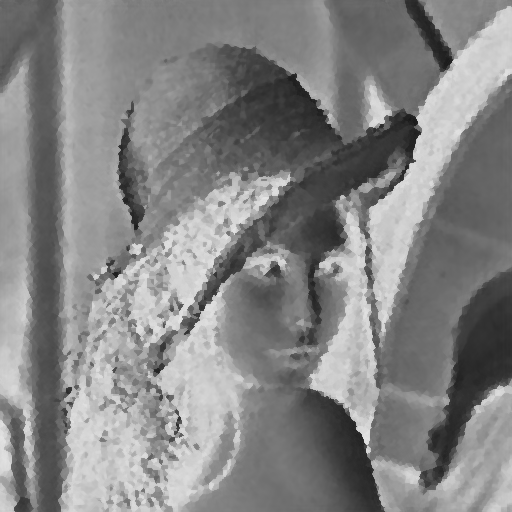

In [6]:
def geo_mean(iterable):
    return np.exp(np.log(iterable).mean())
        
# soft thresholding function
def softh_complex(C, gamma=-1):
    args = np.arctan2(np.imag(C),np.real(C))
    abss = np.abs(C)
    if(gamma == -1):
        gamma = geo_mean(abss)
    maxA = abss - gamma
    maxA = maxA * (maxA > 0)
    softh = np.exp(1j*args)*maxA
    return softh

# the transformation
C = FDCT2D(
    X.shape,
    allcurvelets=True)

# Apparently what's inside C is the base matrix
step1 = np.real(C.H @ softh_complex(C @ X,gamma=-1))
imagesc(step1)

## Soft-threshold DCT

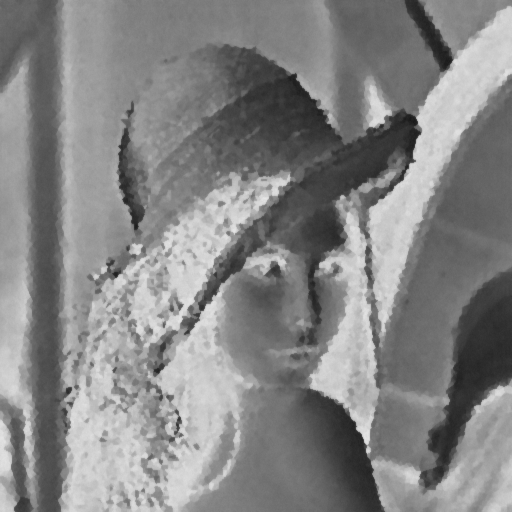

In [7]:
def dct2(block):
    from scipy.fftpack import dct
    return dct(dct(block.T, norm='ortho').T, norm='ortho')
    
def idct2(block):
    from scipy.fftpack import idct
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

def softh_real(coeff,gamma=-1):
    if(gamma == -1):
        gamma = geo_mean(np.abs(coeff.flatten()))
    maxA = abs(coeff) - gamma
    maxA = maxA * (maxA > 0)
    softh = np.sign(coeff)*maxA
    return softh

step2 = idct2(softh_real(dct2(step1),gamma=-1))
imagesc(step2)

## Total Variation

 takes input thTV

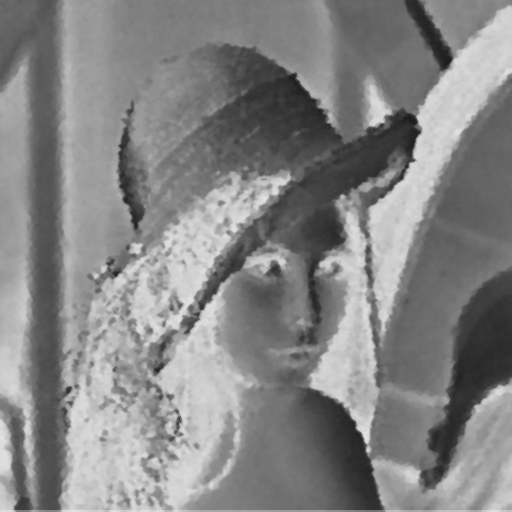

In [8]:
sz = 512
phi1 = np.zeros((sz,sz))
phi1[-1,-1] = 1
phi1[1:,0:-1] = np.eye(sz-1)

phi2 = np.zeros((sz,sz))
phi2[-1,-1] = 1
phi2[0:-1,1:] = np.eye(sz-1)

th_ = step2@(np.eye(sz) -phi1 - phi1.T + phi1@phi1.T)
tv_ = (np.eye(sz) -phi2 - phi1.T + phi1.T@phi1)@step2

thTV = 0.3
step3 = step2 - thTV*(th_ + tv_)
imagesc(step3)

## Compute Residual

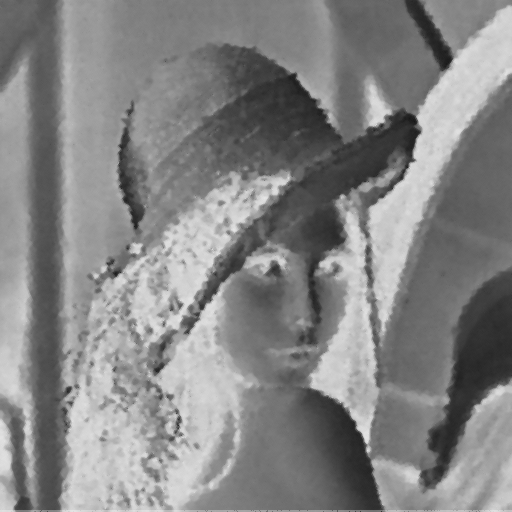

In [9]:
T = M * step3
r = (Y - T)
step4 = step3 + r
imagesc(step4)

# Wrap CS-CVT

In [25]:
def geo_mean(iterable):
    return np.exp(np.log(iterable).mean())
        
# ALL CVT COMPUTATION
def softh_complex(C, gamma=-1):
    args = np.arctan2(np.imag(C),np.real(C))
    abss = np.abs(C)
    if(gamma == -1):
        gamma = geo_mean(abss)
    maxA = abss - gamma
    maxA = maxA * (maxA > 0)
    softh = np.exp(1j*args)*maxA
    return softh

def softh_cvt(X,C,gamma=-1):
    outp = np.real(C.H @ softh_complex(C @ X,gamma=-1))
    normr = np.linalg.norm(C @ outp,1)
    return outp,normr

# ALL DCT COMPUTATION
def dct2(block):
    from scipy.fftpack import dct
    return dct(dct(block.T, norm='ortho').T, norm='ortho')
    
def idct2(block):
    from scipy.fftpack import idct
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

def softh_real(coeff,gamma=-1):
    if(gamma == -1):
        gamma = geo_mean(np.abs(coeff.flatten()))
    maxA = abs(coeff) - gamma
    maxA = maxA * (maxA > 0)
    softh = np.sign(coeff)*maxA
    return softh

def softh_dct(X,gamma=-1):
    outp = idct2(softh_real(dct2(X),gamma=-1))
    normr = np.linalg.norm(dct2(outp),1)
    return outp,normr

# ALL TV COMPUTATION
def tv(X,thTV = 0.01):
    sz = X.shape[0]
    phi1 = np.zeros((sz,sz))
    phi1[-1,-1] = 1
    phi1[1:,0:-1] = np.eye(sz-1)
    
    phi2 = np.zeros((sz,sz))
    phi2[-1,-1] = 1
    phi2[0:-1,1:] = np.eye(sz-1)
    
    th_ = X@(np.eye(sz) -phi1 - phi1.T + phi1@phi1.T)
    tv_ = (np.eye(sz) -phi2 - phi1.T + phi1.T@phi1)@X
    
    outp = X - thTV*(th_ + tv_)

    th_ = outp@(np.eye(sz) -phi1 - phi1.T + phi1@phi1.T)
    tv_ = (np.eye(sz) -phi2 - phi1.T + phi1.T@phi1)@outp
    normr = np.linalg.norm((th_ + tv_),'fro')
    return outp,normr

# compute residual
def residual(Y,X,M):
    T = M * X
    r = (Y - T)
    outp = X + r
    return outp

def CS_CVT(Y,X,M,ITER_MAX=10,**kwargs):
    iternow = 0
    CVT_coeff = FDCT2D(
        X.shape,
        allcurvelets=True)

    itercond = iternow < ITER_MAX
    while itercond:
        # soft-threshold CVT
        step1,p1 = softh_cvt(X,CVT_coeff)
        
        # soft threshold DCT
        step2,p2 = softh_dct(step1)
        
        # TV
        step3,p3 = tv(step2)
        
        # residual
        X = residual(Y,step3,M)

        # show evaluation
        if 'GROUND_TRUTH' in kwargs:
            eval = np.linalg.norm(X-kwargs['GROUND_TRUTH'],'fro');
            print(eval)
        else:
            evalnow = p1+p2+p3 
            if(iternow == 0):
                evalbef = evalnow
            grad = np.abs(evalnow - evalbef) / evalbef
            evalbef = evalnow
            print(grad)
        
        iternow = iternow + 1
        
        itercond = iternow < ITER_MAX
    return step1


In [ ]:
REC = CS_CVT(Y,X,M,ITER_MAX=50)# ,GROUND_TRUTH=I
imagesc(REC)

0.0
0.23597105483337877
0.07954681345848086
0.03815702513080023
0.026144075713632097
0.02009655756880243
0.016346363483543486
